***Exercise 2.3 - Text Mining***

In [1]:
!pip install langdetect

**Path of folder and extracting file name + titles**

In [2]:
import os
import re
from langdetect import detect

# 1. Load Text Files, Extract Titles, and Detect Language
def load_text_files_and_metadata(folder_path):
    file_data = []
    titles = []
    file_names = []
    languages = []
    
    # Iterate through the files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Only process .txt files
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read().strip()  # Read the file content
                
                if content:  # Exclude empty files
                    file_data.append(content)
                    file_names.append(file_name)
                    
                    # Extract title using regex pattern
                    title_match = re.search(r"^(?:Study|Rôle|[A-Za-zé]+.+):?\s+.+$", content, re.M | re.I)
                    if title_match:
                        titles.append(title_match.group(0).strip())  # Extract the title
                    else:
                        titles.append(file_name)  # Fallback to filename if title is not found
                    
                    # Detect language of the content
                    try:
                        languages.append(detect(content))  # Language detection using langdetect
                    except Exception as e:
                        languages.append("unknown")  # Handle cases where detection fails
    
    return file_data, titles, file_names, languages


**Stop words for english and french and also other lanuages (also take into account punctuation like comas, colon and etc)**

In [3]:
import nltk
import scipy
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer

# Download NLTK resources if not already installed
nltk.download('stopwords')
nltk.download('punkt')

# 3. Preprocess Text using NLTK (French and English Stopwords and Stemming)
def preprocess_text(documents, lang):
    processed_docs = []
    for i, doc in enumerate(documents):
        if lang[i] == 'fr':  # Use French stopwords and stemming
            stop_words = set(stopwords.words('french'))
            stemmer = SnowballStemmer('french')
        elif lang[i] == 'en':  # Use English stopwords and stemming
            stop_words = set(stopwords.words('english'))
            stemmer = SnowballStemmer('english')
        else:  # Skip preprocessing for unsupported or unknown languages
            processed_docs.append(doc)
            continue
        
        tokens = regexp_tokenize(doc, pattern=r'\s|[\.,;?!\(\)"]', gaps=True)
        filtered_tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words and word.isalpha()]
        processed_docs.append(" ".join(filtered_tokens))
    
    return processed_docs


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TF-IDF Vectorization and Cosine Similarity**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


#TF-IDF Vectorization and Cosine Similarity
def compute_similarity(documents, titles):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    similarity_df = pd.DataFrame(similarity_matrix, index=titles, columns=titles)
    return similarity_df


**Force-Directed Graph code using similarity as weight**

In [5]:
import networkx as nx

#Code for the creation of force directed graph with similarity as weight
def create_force_directed_graph(similarity_df, threshold=0.2):
    G = nx.Graph()
    for node in similarity_df.index:
        G.add_node(node)
    for i, row in similarity_df.iterrows():
        for j, similarity in row.items():
            if i != j and similarity >= threshold:
                G.add_edge(i, j, weight=similarity)
    return G


In [6]:
import matplotlib.pyplot as plt

def visualize_graph(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color="skyblue",
        edge_color="gray",
        node_size=2000,
        font_size=10
    )
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()},
        font_color='red'
    )
    plt.title("Force-Directed Graph of Document Similarities")
    plt.show()


File: tel-03435883.txt | Title: Les systèmes Toxine-Antitoxine VapBC : des régulateurs

   de la symbiose fixatrice d’azote Rhizobium-Légumineuse | Language: fr
File: tel-03435884.txt | Title: Étude phylogénique de souches d’alphaherpèsvirus

    isolées chez les équidés français et développement d’un | Language: fr
File: tel-03435885.txt | Title: Multi-scale studies of Measeles virus nucleocapsid

                              assembly | Language: fr
File: tel-03435936.txt | Title: Caractérisation génomique des anomalies de la

                 pigmentation cutanée en mosaïque | Language: fr
File: tel-03436011.txt | Title: Le Conseil économique, social et environnemental

     régional : assemblée du dialogue des intérêts organisés | Language: fr
File: tel-03436023.txt | Title: Optical Developments for Microscale Measurement and

            Control of Temperature in Optogenetics | Language: fr
File: tel-03436024.txt | Title: Z-boson and double charm production with ALICE at

        

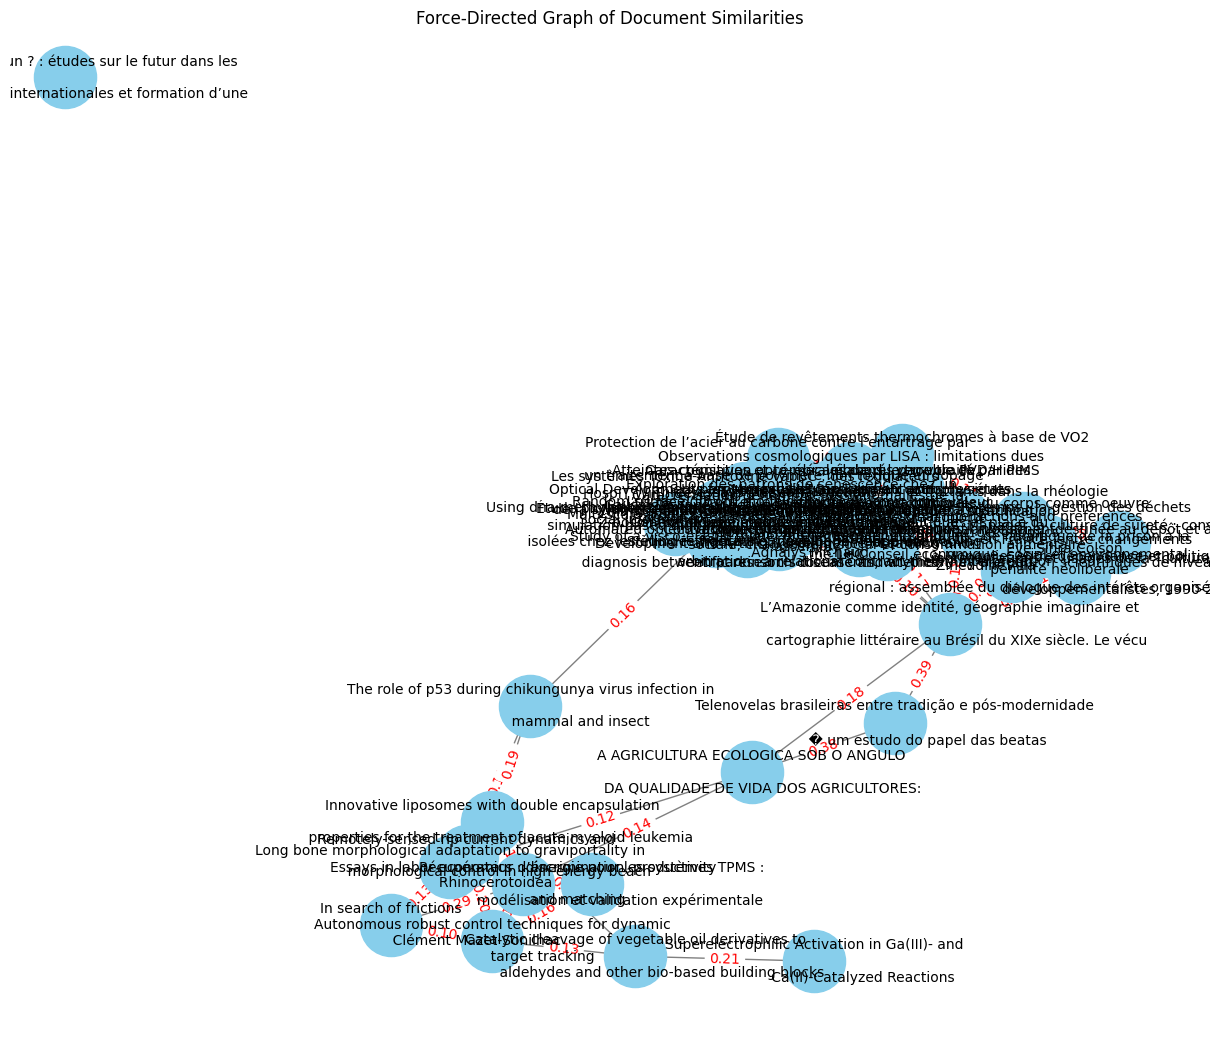

In [7]:
# Set the folder path where text files are stored
folder_path = r"C:\Users\alexh\Downloads\NLP\Tel_text"

# Load text files, extract titles, and detect language
file_data, titles, file_names, languages = load_text_files_and_metadata(folder_path)

if not file_data:
    raise ValueError("No valid documents found. Ensure your folder contains non-empty .txt files.")

#Create DataFrame containing document content
doc_df = pd.DataFrame({
    'File Name': file_names,
    'Title': titles,
    'Language': languages,
    'Content': file_data
})

#detected languages and titles
for name, title, lang in zip(file_names, titles, languages):
    print(f"File: {name} | Title: {title} | Language: {lang}")

#Preprocess the docs based on their detected language
processed_documents = preprocess_text(file_data, languages)

#Compute similarity matrix
similarity_df = compute_similarity(processed_documents, titles)

#Save similarity matrix to CSV
output_file = "theses_similarity_with_languages.csv"
similarity_df.to_csv(output_file)
metadata_file = "theses_metadata.csv"
pd.DataFrame({'File Name': file_names, 'Title': titles, 'Language': languages}).to_csv(metadata_file, index=False)
print(f"Similarity matrix saved as '{output_file}'")
print(f"Metadata saved as '{metadata_file}'")

#force-directed graph
threshold = 0.1
G = create_force_directed_graph(similarity_df, threshold=threshold)

visualize_graph(G)


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

#first 5 documents as a subset
relevant_texts = doc_df["Content"][:5]  

#Train Bigram model on the relevant part of the dataset
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
bigram_matrix = bigram_vectorizer.fit_transform(relevant_texts)

#Convert bigram matrix to DataFrame
bigram_df = pd.DataFrame(
    bigram_matrix.toarray(),
    columns=bigram_vectorizer.get_feature_names_out(),
    index=range(len(relevant_texts))  
)

#Reshape and process the DataFrame for sorting
bigram_df = bigram_df.stack().reset_index()
bigram_df = bigram_df.rename(columns={0: 'tfidf', 'level_0': 'document', 'level_1': 'term'})

bigram_df['document'] = bigram_df['document'].apply(lambda idx: doc_df["File Name"].iloc[idx])

#Sort and group to get top bigrams for each document
top_bigrams = (
    bigram_df.sort_values(by=['document', 'tfidf'], ascending=[True, False])
    .groupby(['document'])
    .head(10)
)

#Train Trigram model on the relevant part of the dataset
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_matrix = trigram_vectorizer.fit_transform(relevant_texts)

#Convert trigram matrix to DataFrame
trigram_df = pd.DataFrame(
    trigram_matrix.toarray(),
    columns=trigram_vectorizer.get_feature_names_out(),
    index=range(len(relevant_texts))  # Use numerical indices for processing
)

#Reshape and process the DataFrame for sorting
trigram_df = trigram_df.stack().reset_index()
trigram_df = trigram_df.rename(columns={0: 'tfidf', 'level_0': 'document', 'level_1': 'term'})

#Map the numerical index back to file names
trigram_df['document'] = trigram_df['document'].apply(lambda idx: doc_df["File Name"].iloc[idx])

#Sort and group to get top trigrams for each document
top_trigrams = (
    trigram_df.sort_values(by=['document', 'tfidf'], ascending=[True, False])
    .groupby(['document'])
    .head(10)
)

top_bigrams_path = "C:\\Users\\alexh\\Downloads\\NLP\\top_bigrams.csv"
top_trigrams_path = "C:\\Users\\alexh\\Downloads\\NLP\\top_trigrams.csv"

top_bigrams.to_csv(top_bigrams_path, index=False)
top_trigrams.to_csv(top_trigrams_path, index=False)

#Save location
print(f"Top bigrams saved to '{top_bigrams_path}'")
print(f"Top trigrams saved to '{top_trigrams_path}'")

#Display result
bigram_df_read = pd.read_csv(top_bigrams_path)
trigram_df_read = pd.read_csv(top_trigrams_path)

print("\nTop Bigrams:")
print(bigram_df_read.head())

print("\nTop Trigrams:")
print(trigram_df_read.head())

Top bigrams saved to 'C:\Users\alexh\Downloads\NLP\top_bigrams.csv'
Top trigrams saved to 'C:\Users\alexh\Downloads\NLP\top_trigrams.csv'

Top Bigrams:
           document         term  tfidf
0  tel-03435883.txt        et al    990
1  tel-03435883.txt        de la    866
2  tel-03435883.txt    la toxine    344
3  tel-03435883.txt       of the    276
4  tel-03435883.txt  systèmes ta    203

Top Trigrams:
           document             term  tfidf
0  tel-03435883.txt     de la toxine    159
1  tel-03435883.txt       et al 2014     98
2  tel-03435883.txt       et al 2017     87
3  tel-03435883.txt  des systèmes ta     85
4  tel-03435883.txt       de type ii     77


***Exercise 2.4 - POS-tagging and exercise generation***

In [9]:
!pip install stanza

In [10]:
!pip install spacy

In [11]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install packaging

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import spacy
import pandas as pd
import random

#SpaCy's English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Model 'en_core_web_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

#Ensure the data has an English column
if "English" not in df.columns:
    raise ValueError("No 'English' column found in the sheet!")

#Function to extract noun and pronoun details
def extract_noun_pronoun_details(sentence):
    #Process the sentence
    doc = nlp(sentence)  
    details = {
        "nouns": [],
        "pronouns": []
    }
    
    for token in doc:
        #Identify nouns
        if token.pos_ == "NOUN":  
            details["nouns"].append({
                "word": token.text,
                "position": token.i
            })
        #Identify pronouns
        elif token.pos_ == "PRON":  
            details["pronouns"].append({
                "word": token.text,
                "position": token.i
            })
    
    return details

#Apply the extraction function to the English sentences
df["Noun_Pronoun_Details"] = df["English"].apply(
    lambda x: extract_noun_pronoun_details(x) if isinstance(x, str) else {"nouns": [], "pronouns": []}
)

#Prepare data for saving extracted nouns and pronouns
noun_pronoun_data = []
for index, row in df.iterrows():
    for noun in row["Noun_Pronoun_Details"]["nouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["English"],
            "word": noun["word"],
            "part_of_speech": "NOUN",
            "position": noun["position"]
        })
    for pronoun in row["Noun_Pronoun_Details"]["pronouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["English"],
            "word": pronoun["word"],
            "part_of_speech": "PRONOUN",
            "position": pronoun["position"]
        })

noun_pronoun_df = pd.DataFrame(noun_pronoun_data)

noun_pronoun_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\Extracted_Nouns_Pronouns_English.xlsx"
noun_pronoun_df.to_excel(noun_pronoun_output_path, index=False)

print(f"Extracted Nouns and Pronouns saved to {noun_pronoun_output_path}")

#MCQs for identifying nouns and pronouns
def generate_mcq(row):
    try:
        #Extract words from the sentence in this case get first 5 words
        words_in_sentence = row["sentence"].split()[:5] 
        
        #Randomize for MCQ
        options = random.sample(words_in_sentence, len(words_in_sentence))
        
        #Determine the question type (NOUN or PRONOUN)
        correct_pos = row["part_of_speech"]
        question_type = "pronoun" if correct_pos == "PRONOUN" else "noun"
        
        mcq = {
            "question": f"Which of the following words is a {question_type}? ({', '.join(words_in_sentence)})",
            "options": ", ".join(options),
            "correct_answer": row["word"]
        }
        return mcq
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
        return None

#Generate MCQs for nouns and pronouns
mcq_data = []
for _, row in noun_pronoun_df.iterrows():
    mcq = generate_mcq(row)
    if mcq:
        mcq_data.append(mcq)

#New DataFrame for the generated MCQs
mcq_df = pd.DataFrame(mcq_data)

#Note: saved to my personal location but can modify it
mcq_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\MCQs in English.xlsx"
mcq_df.to_excel(mcq_output_path, index=False)

print(f"MCQs for Nouns and Pronouns saved to {mcq_output_path}")


Extracted Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\Extracted_Nouns_Pronouns.xlsx
MCQs for Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\MCQs in English.xlsx


In [ ]:
import spacy
import pandas as pd
import random

#SpaCy's German model
try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Model 'de_core_news_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("de_core_news_sm")
    nlp = spacy.load("de_core_news_sm")

file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

#Check data has a column called German
if "German" not in df.columns:
    raise ValueError("No 'German' column found in the sheet!")

#Function to extract noun details
def extract_noun_details(sentence):
    #Process the sentence
    doc = nlp(sentence)  
    details = []
    for token in doc:
        #Identify nouns
        if token.pos_ == "NOUN":  
            details.append({
                "noun": token.text,
                "gender": token.morph.get("Gender", [None])[0],
                "case": token.morph.get("Case", [None])[0],
                "position": token.i
            })
    return details

#Add noun details to the DataFrame
df["Noun_Details"] = df["German"].apply(
    lambda x: extract_noun_details(x) if isinstance(x, str) else []
)

#Transform the data for MCQ generation
nouns_data = []
for index, row in df.iterrows():
    for detail in row["Noun_Details"]:
        nouns_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "noun": detail["noun"],
            "gender": detail["gender"],
            "case": detail["case"],
            "position": detail["position"]
        })

nouns_df = pd.DataFrame(nouns_data)

#Check that it has necessary columns for MCQ generation
if not {"sentence", "noun", "gender", "case"}.issubset(nouns_df.columns):
    missing = {"sentence", "noun", "gender", "case"} - set(nouns_df.columns)
    raise ValueError(f"Missing required columns: {', '.join(missing)}")

#Function to generate german MCQs
def generate_mcq(row):
    try:
        #Gender question
        gender_options = ["Masc", "Fem", "Neut"]
        correct_gender = row["gender"]

        if correct_gender not in gender_options:
            print(f"Invalid gender '{correct_gender}' for noun '{row['noun']}'")
            return None, None

        gender_distractors = random.sample([g for g in gender_options if g != correct_gender], 2)
        gender_mcq = {
            "question": f"What is the gender of the noun '{row['noun']}'?",
            "options": random.sample([correct_gender] + gender_distractors, 3),  # Shuffle options
            "correct_answer": correct_gender
        }

        #Case question
        case_options = ["Nom", "Acc", "Dat", "Gen"]
        correct_case = row["case"]

        if correct_case not in case_options:
            print(f"Invalid case '{correct_case}' for noun '{row['noun']}'")
            return None, None

        case_distractors = random.sample([c for c in case_options if c != correct_case], 3)
        case_mcq = {
            "question": f"What is the case of the noun '{row['noun']}' in the sentence: '{row['sentence']}'?",
            "options": random.sample([correct_case] + case_distractors, 4), 
            "correct_answer": correct_case
        }

        return gender_mcq, case_mcq
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
        return None, None

#MCQs
mcq_data = []
for _, row in nouns_df.iterrows():
    gender_mcq, case_mcq = generate_mcq(row)
    if gender_mcq and case_mcq:
        mcq_data.extend([gender_mcq, case_mcq])

mcq_df = pd.DataFrame(mcq_data)
output_path = "C:\\Users\\alexh\\Downloads\\NLP\\MCQ_German.xlsx"
mcq_df.to_excel(output_path, index=False)

print(f"MCQ exercises saved to {output_path}")


Invalid gender 'None' for noun 'Reisenden'
Invalid gender 'None' for noun 'Torten'
Invalid case 'None' for noun 'Trockenheit'
Invalid gender 'None' for noun 'Anderen'
Invalid gender 'None' for noun 'Leute'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Bremsenstiche'
Invalid gender 'None' for noun 'Tintenfische'
Invalid gender 'None' for noun 'Beuteltiere'
Invalid gender 'None' for noun 'Kabeljaue'
Invalid gender 'None' for noun 'Ofen'
Invalid case 'None' for noun 'Infektion'
Invalid case 'None' for noun 'Kälte'
Invalid gender 'None' for noun 'Ferien'
Invalid gender 'None' for noun 'Gläubige'
Invalid gender 'None' for noun 'Toten'
Invalid gender 'None' for noun 'Leute'
Invalid gender 'None' for noun 'Ohrringe'
Invalid gender 'None' for noun 'Kosten'
Invalid case 'None' for noun 'Trockenheit'
Invalid case 'None' for noun 'Wilderei'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Eltern'
Invalid gend

In [16]:
import spacy
import pandas as pd
import random

# Load SpaCy's German model
try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Model 'de_core_news_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("de_core_news_sm")
    nlp = spacy.load("de_core_news_sm")

# File path for the input Excel file
file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

# Ensure the data has a 'German' column
if "German" not in df.columns:
    raise ValueError("No 'German' column found in the sheet!")

# Function to extract noun and pronoun details
def extract_noun_pronoun_details(sentence):
    doc = nlp(sentence)  # Process the sentence
    details = {
        "nouns": [],
        "pronouns": []
    }
    
    for token in doc:
        if token.pos_ == "NOUN":  # Identify nouns
            details["nouns"].append({
                "word": token.text,
                "position": token.i
            })
        elif token.pos_ == "PRON":  # Identify pronouns
            details["pronouns"].append({
                "word": token.text,
                "position": token.i
            })
    
    return details

# Apply the extraction function to the German sentences
df["Noun_Pronoun_Details"] = df["German"].apply(
    lambda x: extract_noun_pronoun_details(x) if isinstance(x, str) else {"nouns": [], "pronouns": []}
)

# Prepare data for saving extracted nouns and pronouns
noun_pronoun_data = []
for index, row in df.iterrows():
    for noun in row["Noun_Pronoun_Details"]["nouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "word": noun["word"],
            "part_of_speech": "NOUN",
            "position": noun["position"]
        })
    for pronoun in row["Noun_Pronoun_Details"]["pronouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "word": pronoun["word"],
            "part_of_speech": "PRONOUN",
            "position": pronoun["position"]
        })

# Create a DataFrame for the extracted nouns and pronouns
noun_pronoun_df = pd.DataFrame(noun_pronoun_data)

# Save the extracted nouns and pronouns to an Excel file
noun_pronoun_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\Extracted_Nouns_Pronouns_German.xlsx"
noun_pronoun_df.to_excel(noun_pronoun_output_path, index=False)

print(f"Extracted Nouns and Pronouns saved to {noun_pronoun_output_path}")


Extracted Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\Extracted_Nouns_Pronouns_German.xlsx
